In [1]:
#Harsimar Mangat
#Exercise 7.1

from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

def RunTests(live, iters=1000):
    """Runs the tests from Chapter 9 with a subset of the data.

    live: DataFrame
    iters: how many iterations to run
    """
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))


In [2]:
n = len(live)
for _ in range(5):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2
    
    # Solution

# My results:

# n       test1   test2   test2   test4
#9148	0.19	0.00	0.00	0.00
#4574	0.42	0.00	0.00	0.00
#2287	0.92	0.09	0.00	0.00
#1143	0.11	0.88	0.23	0.00
#571	0.27	0.07	0.08	0.28

#Our p values 
#If we decrease the smaple size, we're increasing the standard error, or decreasing the 
#difference between thevsample sttaistic and the hypothesize paramter. 
#So the p value INCREASES, making it more likley we dont reject the null hypothesis


#A positive p value is anything less than 0.05. With sample size of 571, none of our tests were statistically signifcant



9148	0.17	0.00	0.00	0.00
4574	0.72	0.00	0.00	0.00
2287	0.86	0.04	0.03	0.00
1143	0.59	0.81	0.10	0.09
571	0.06	0.71	0.87	0.34


mean, SE, CI 7.345553360211856 0.014026397779876578 (7.324106846587767, 7.368035536090476)
mean, SE, CI 7.266584317903693 0.013418428182672922 (7.244927216585796, 7.289283738938053)


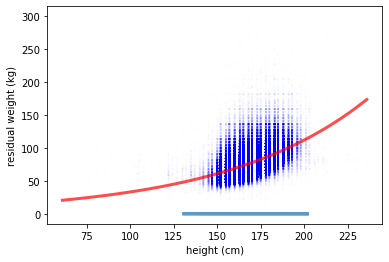

In [3]:

from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

import brfss


def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)
        
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)




def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)
    

def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample



iters = 100
estimates = [ResampleRowsWeighted(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)



df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)



res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)







In [4]:
#Correlation - 0.53
rho = thinkstats2.Corr(heights, log_weights)
rho

#Coeffecient of Determination - .28273
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

std_ys = thinkstats2.Std(log_weights)
std_ys

std_res = thinkstats2.Std(res)
std_res
# 0.08

1 - std_res / std_ys

0.15308497658793419

In [5]:

t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)
    
inters, slopes = zip(*t)

# mean, SE, CI 7.348006433300339 0.014577482863043195 (7.326749028317601, 7.372265408106608)



0.0

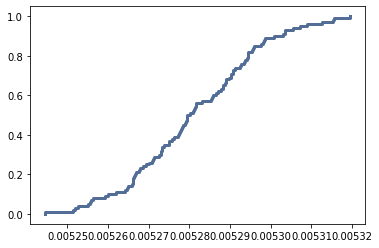

In [6]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)


pvalue = cdf[0]
pvalue

In [7]:
#90% confidence interval
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

#(0.00525514352340767, 0.0053071928724027)

(0.00525514352340767, 0.0053071928724027)

In [8]:
mean = thinkstats2.Mean(slopes)
mean
# 0.005281193472802755






0.005281193472802755

In [9]:
stderr = thinkstats2.Std(slopes)
stderr
# 1.5680513912229875e-05

1.5680513912229875e-05

In [10]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)
# mean, SE, CI 168.95668286040546 0.016871515649535616 (168.93189029689364, 168.98958901756302)

mean, SE, CI 168.95668286040546 0.016871515649535616 (168.93189029689364, 168.98958901756302)


In [11]:
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)
#mean, SE, CI 170.49775121768835 0.017321428351262987 (170.46627357060572, 170.5233432365246)

#If we used the estimated weight, we see that there is about a 2 cm difference, which is higher than the standard error


mean, SE, CI 170.49775121768835 0.017321428351262987 (170.46627357060572, 170.5233432365246)
